# 데이터셋

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
import librosa
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [3]:
raw_data = speech_data["wav_vals"]
print("Waveform shape : ",raw_data.shape)

Waveform shape :  (50620, 8000)


In [4]:
data = []
for r in raw_data[:30000]:
    data.append(wav2spec(r))
data = np.array(data)
print("Spectrogram shape : ",data.shape)

Spectrogram shape :  (30000, 130, 126)


# 데이터 처리와 분류

## 라벨 데이터 처리

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [6]:
temp = []
for v in speech_data["label_vals"][:30000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

In [7]:
from sklearn.model_selection import train_test_split
train_wav, test_wav, train_label, test_label = train_test_split(data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (27000, 130, 126)
train labels :  (27000,)
test data :  (3000, 130, 126)
test labels :  (3000,)


## Hyper-parameters setting

In [8]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel42/aiffel/speech_recognition/models/wav'

## Data setting

In [9]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [10]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


# Wave classification 모델 구현
## Model

In [11]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)           

## Loss

In [12]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

## Training

In [13]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [14]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
209/210 [============================>.] - ETA: 0s - loss: 1.7802 - accuracy: 0.3848
Epoch 00001: val_loss improved from inf to 2.17095, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav
210/210 [==============================] - 3s 16ms/step - loss: 1.7781 - accuracy: 0.3854 - val_loss: 2.1710 - val_accuracy: 0.5251
Epoch 2/10
209/210 [============================>.] - ETA: 0s - loss: 1.0059 - accuracy: 0.6542
Epoch 00002: val_loss improved from 2.17095 to 1.18145, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav
210/210 [==============================] - 3s 15ms/step - loss: 1.0046 - accuracy: 0.6546 - val_loss: 1.1815 - val_accuracy: 0.7378
Epoch 3/10
209/210 [============================>.] - ETA: 0s - loss: 0.6380 - accuracy: 0.7851
Epoch 00003: val_loss improved from 1.18145 to 0.62129, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav
210/210 [==============================] - 3s 15ms/step - loss: 0.6378 - accurac

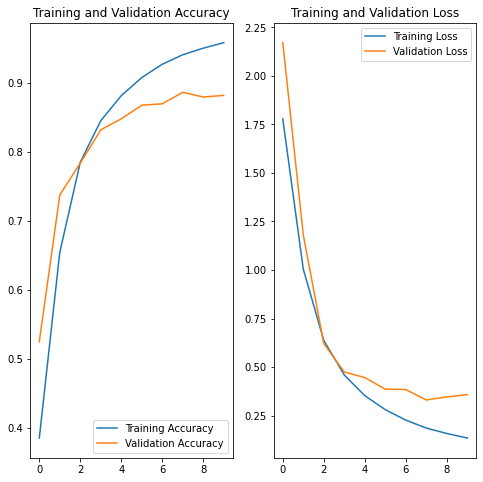

In [15]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [18]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

24/24 [==============================] - 0s 5ms/step - loss: 0.3340 - accuracy: 0.8853


In [19]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.334
accuracy value: 88.5333%


## Model Test

In [22]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  no


In [24]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: no


# Skip-Connection model

## Model

In [26]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
_______________________________________________________________________________________

## Loss

In [27]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

## Training

In [28]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [29]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
210/210 [==============================] - ETA: 0s - loss: 1.9326 - accuracy: 0.3588
Epoch 00001: val_loss improved from inf to 1.51812, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 4s 18ms/step - loss: 1.9326 - accuracy: 0.3588 - val_loss: 1.5181 - val_accuracy: 0.5190
Epoch 2/10
209/210 [============================>.] - ETA: 0s - loss: 1.1505 - accuracy: 0.6013
Epoch 00002: val_loss improved from 1.51812 to 0.96910, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 4s 18ms/step - loss: 1.1490 - accuracy: 0.6016 - val_loss: 0.9691 - val_accuracy: 0.6610
Epoch 3/10
210/210 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.7319
Epoch 00003: val_loss improved from 0.96910 to 0.69945, saving model to /home/aiffel42/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 4s 18ms/step - loss: 0

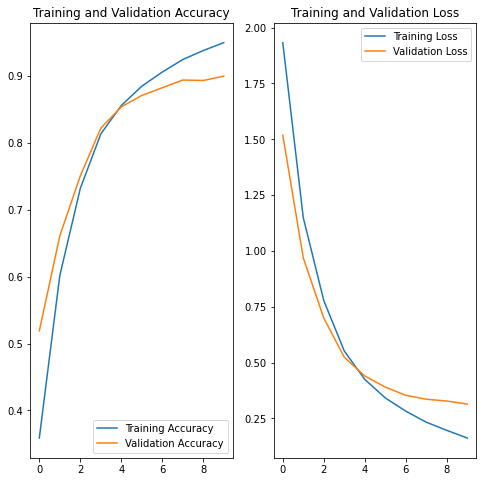

In [30]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [31]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

24/24 [==============================] - 0s 7ms/step - loss: 0.3196 - accuracy: 0.8973
loss value: 0.320
accuracy value: 89.7333%


## Model Test

In [32]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


label :  stop


In [34]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: stop
